In [ ]:
"""
Toxic Comment Classification for Prompt Guardrails

This notebook fine-tunes a DistilBERT-based text classifier using the Jigsaw Toxic Comment Classification dataset.
The goal is to classify text prompts into binary labels: 'safe' and 'unsafe'.
The trained model can act as a guardrail filter before generative AI systems process prompts.

Author: Nagaraju Kuruva
Date: May 2025
Environment: Google Colab & Kaggle Notebook with GPU
Reference: https://huggingface.co/datasets/google/jigsaw_toxicity_pred & https://www.kaggle.com/competitions/jigsaw-toxic-comment-classification-challenge
"""

In [ ]:
# ==================== Imports ====================
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import DistilBertTokenizer, DistilBertModel
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score, confusion_matrix,roc_curve,auc
from sklearn.model_selection import train_test_split
from wordcloud import WordCloud
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from matplotlib_venn import venn3

In [ ]:
# ==================== Device Setup ====================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [ ]:
# ====================  Connect to Kaggle API to download data ===================
# Log into Kaggle(https://www.kaggle.com/) --> Go to Settings ---> Account --> API ---> Click on Create New Token button ---> Click on Continue --> It will download kaggale.json file
from google.colab import files
files.upload()  # Upload kaggle.json here

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"nagarajukuruva","key":"10905af2e1b8a2b5e0394caa9a3b5478"}'}

In [ ]:
# Create a directory to store API key and get API connection.
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
os.environ['KAGGLE_CONFIG_DIR'] = "/root/.kaggle"

In [ ]:
# Downlaod the data and unzip it.
!kaggle competitions download -c jigsaw-toxic-comment-classification-challenge
!unzip jigsaw-toxic-comment-classification-challenge.zip

  0% 0.00/52.6M [00:00<?, ?B/s]
100% 52.6M/52.6M [00:00<00:00, 726MB/s]
Archive:  jigsaw-toxic-comment-classification-challenge.zip
  inflating: sample_submission.csv.zip  
  inflating: test.csv.zip            
  inflating: test_labels.csv.zip     
  inflating: train.csv.zip           


In [ ]:
# ==================== Load and Preprocess Training Data - Google Colab Platform ====================
try:
    train_data = pd.read_csv('train.csv.zip')
    print(f"Training samples: {len(train_data)}")
except Exception as e:
    raise RuntimeError("Error loading training data.") from e

Training samples: 159571


In [ ]:
# ==================== Load and Preprocess Training Data - Kaggle Platform ====================
try:
    train_data = pd.read_csv('/kaggle/input/toxicv1/train.csv')
    print(f"Training samples: {len(train_data)}")
except Exception as e:
    raise RuntimeError("Error loading training data.") from e

Training samples: 159571


In [ ]:
## Check dimensions of train data.
print(train_data.shape)

(159571, 8)


In [ ]:
## Check first record of train data.
train_data.head(1)

id                                       comment_text  toxic  \
0  0000997932d777bf  Explanation\nWhy the edits made under my usern...      0   

   severe_toxic  obscene  threat  insult  identity_hate  
0             0        0       0       0              0

In [ ]:
## Get summary statistics of train data.
train_data.describe(include='all')

id                                       comment_text  \
count             159571                                             159571   
unique            159571                                             159571   
top     fff46fc426af1f9a  "\nAnd ... I really don't think you understand...   
freq                   1                                                  1   
mean                 NaN                                                NaN   
std                  NaN                                                NaN   
min                  NaN                                                NaN   
25%                  NaN                                                NaN   
50%                  NaN                                                NaN   
75%                  NaN                                                NaN   
max                  NaN                                                NaN   

                toxic   severe_toxic        obscene         threat  \
count   159571.000000  159571.000000  159571.000000  159571.000000   
unique            NaN            NaN            NaN            NaN   
top               NaN            NaN            NaN            NaN   
freq              NaN            NaN            NaN            NaN   
mean         0.095844       0.009996       0.052948       0.002996   
std          0.294379       0.099477       0.223931       0.054650   
min          0.000000       0.000000       0.000000       0.000000   
25%          0.000000       0.000000       0.000000       0.000000   
50%          0.000000       0.000000       0.000000       0.000000   
75%          0.000000       0.000000       0.000000       0.000000   
max          1.000000       1.000000       1.000000       1.000000   

               insult  identity_hate  
count   159571.000000  159571.000000  
unique            NaN            NaN  
top               NaN            NaN  
freq              NaN            NaN  
mean         0.049364       0.008805  
std          0.216627       0.093420  
min          0.000000       0.000000  
25%          0.000000       0.000000  
50%          0.000000       0.000000  
75%          0.000000       0.000000  
max          1.000000       1.000000

In [ ]:
## Get train data column names.
train_data.columns

Index(['id', 'comment_text', 'toxic', 'severe_toxic', 'obscene', 'threat',
       'insult', 'identity_hate'],
      dtype='object')

In [ ]:
## Get index range for train data.
train_data.index

RangeIndex(start=0, stop=159571, step=1)

In [ ]:
## Get data types for train data columns.
train_data.dtypes

id               object
comment_text     object
toxic             int64
severe_toxic      int64
obscene           int64
threat            int64
insult            int64
identity_hate     int64
dtype: object

In [ ]:
## Check null values for train data.
train_data.isna().sum()

id               0
comment_text     0
toxic            0
severe_toxic     0
obscene          0
threat           0
insult           0
identity_hate    0
dtype: int64

We **don't** have any **NA**'s in the training data.

In [ ]:
## Below method/function returns data types,levels,NA values,unique values for the given data frame.

def getStatistics(df):
    return pd.DataFrame({'dtypes' : df.dtypes,
                         'levels' : [df[column].unique() for column in df.columns],
                         'NA  Values' : df.isna().sum(),
                         'Unique Values' :  df.nunique()
                        })

In [ ]:
## Get data types,levels,NA values,unique values for train data.
getStatistics(train_data)

dtypes                                             levels  \
id             object  [0000997932d777bf, 000103f0d9cfb60f, 000113f07...   
comment_text   object  [Explanation\nWhy the edits made under my user...   
toxic           int64                                             [0, 1]   
severe_toxic    int64                                             [0, 1]   
obscene         int64                                             [0, 1]   
threat          int64                                             [0, 1]   
insult          int64                                             [0, 1]   
identity_hate   int64                                             [0, 1]   

               NA  Values  Unique Values  
id                      0         159571  
comment_text            0         159571  
toxic                   0              2  
severe_toxic            0              2  
obscene                 0              2  
threat                  0              2  
insult                  0              2  
identity_hate           0              2

We **don't** have **null** values in the train data and we can see **2 levels** for label columns.

In [ ]:
## Below logic is used for checking special characters in numeric columns.

def specialCharcterVerification_NumCol(data):
    for col in data.select_dtypes(['int64','float64']).columns:
        print('\n',col,'----->')
        for index in range(1,len(data)):
            try:
                skip=float(data.loc[index,col])
                skip=int(data.loc[index,col])
            except ValueError :
                if(str(data.loc[index,col]) != 'nan'):
                    print(index,data.loc[index,col])

In [ ]:
## Check special charcters for train data numeric columns.
specialCharcterVerification_NumCol(train_data)


 toxic ----->

 severe_toxic ----->

 obscene ----->

 threat ----->

 insult ----->

 identity_hate ----->


We **don't** have any **special charcters** in label columns

In [ ]:
## calculate variance column wise.
def variance(x):
        return(pd.DataFrame({'Datatype' : x.dtypes,
                            'Variance': [round(x[i].var()) for i in x] }))

In [ ]:
## Get variance for train data numeric columns.
variance(train_data.select_dtypes(['int64','float64']))

Datatype  Variance
toxic            int64         0
severe_toxic     int64         0
obscene          int64         0
threat           int64         0
insult           int64         0
identity_hate    int64         0

The variance for the label columns is **zero** due to the **low** proportion of **unsafe** comments in the dataset.

In [ ]:
## Check for corrlation between numeric columns of train data.
train_data[train_data.select_dtypes(['int64','float64']).columns].corr()

toxic  severe_toxic   obscene    threat    insult  \
toxic          1.000000      0.308619  0.676515  0.157058  0.647518   
severe_toxic   0.308619      1.000000  0.403014  0.123601  0.375807   
obscene        0.676515      0.403014  1.000000  0.141179  0.741272   
threat         0.157058      0.123601  0.141179  1.000000  0.150022   
insult         0.647518      0.375807  0.741272  0.150022  1.000000   
identity_hate  0.266009      0.201600  0.286867  0.115128  0.337736   

               identity_hate  
toxic               0.266009  
severe_toxic        0.201600  
obscene             0.286867  
threat              0.115128  
insult              0.337736  
identity_hate       1.000000

We can observe a **good** **linear relationship** between the **toxic**, **obscene**, and **insult** labels.


In [ ]:
## Get missing percentage of NA values.
def missingValuesPercentage(Data):
    missing_values = (Data.isna().sum() /len(Data)).round(4) * 100
    print(missing_values.sort_values(ascending = False))

In [ ]:
## Get NA values count in percentage for train data.
missingValuesPercentage(train_data)

id               0.0
comment_text     0.0
toxic            0.0
severe_toxic     0.0
obscene          0.0
threat           0.0
insult           0.0
identity_hate    0.0
dtype: float64


We got **0%** as we don't have any **NA**'s in training data.

In [ ]:
## Drop duplicate records for train data.
train_data = train_data.drop_duplicates()

In [ ]:
##Exploratory Data Analysis ( EDA )

In [ ]:
#Univariant Analysis

<Axes: xlabel='obscene', ylabel='count'>

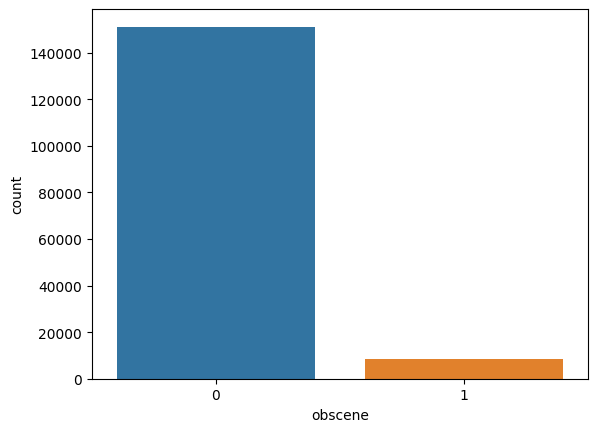

In [ ]:
# Chceck the frequency count of obscene.
sns.countplot(x='obscene',data=train_data)

We can observe that there are **very few** instances of **obscene** words in the **comments**.


In [8]:
# Display each count level for obscene column.
train_data.obscene.value_counts()

obscene
0    151122
1      8449
Name: count, dtype: int64

<Axes: xlabel='insult', ylabel='count'>

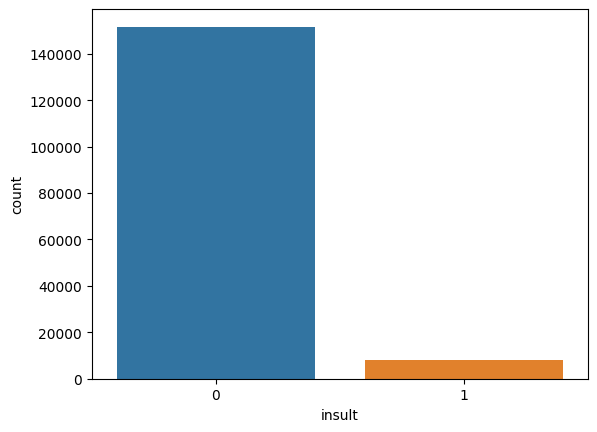

In [ ]:
# Chceck the frequency count of insult.
sns.countplot(x='insult',data=train_data)

We can observe that there are **very few** instances of **insulting** words in the **comments**.


In [7]:
# Display each count level for insult column.
train_data.insult.value_counts()

insult
0    151694
1      7877
Name: count, dtype: int64

<Axes: xlabel='toxic', ylabel='count'>

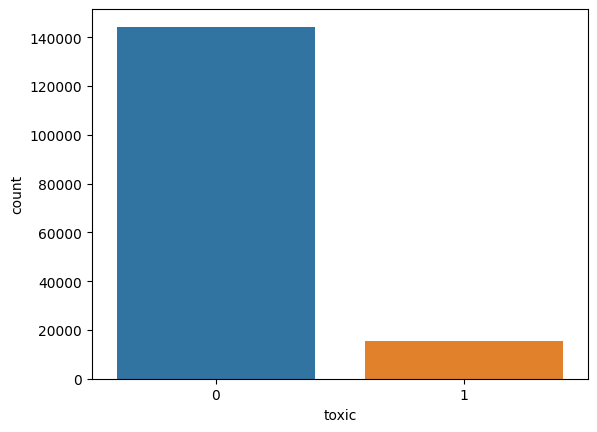

In [ ]:
# Chceck the frequency count of toxic.
sns.countplot(x='toxic',data=train_data)

We can observe that there are **very few** instances of **toxic** words in the **comments**.


In [ ]:
# Display each count level for toxic column.
train_data.toxic.value_counts()

toxic
0    144277
1     15294
Name: count, dtype: int64

<Axes: xlabel='identity_hate', ylabel='count'>

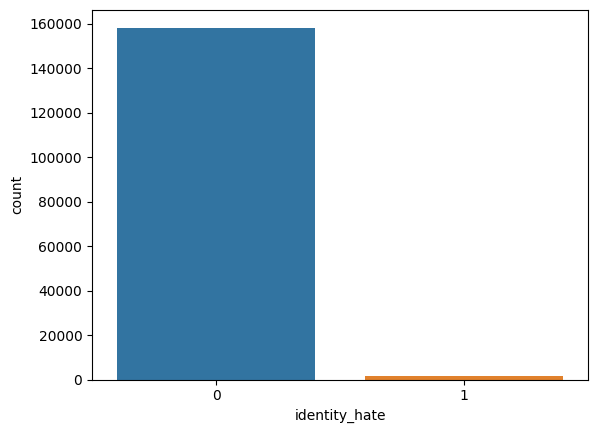

In [ ]:
# Chceck the frequency count of identity_hate.
sns.countplot(x='identity_hate',data=train_data)

We can observe that there are **very few** instances of **identity_hate** words in the **comments**.

In [9]:
# Display each count level for identity_hate column.
train_data.identity_hate.value_counts()

identity_hate
0    158166
1      1405
Name: count, dtype: int64

<Axes: xlabel='threat', ylabel='count'>

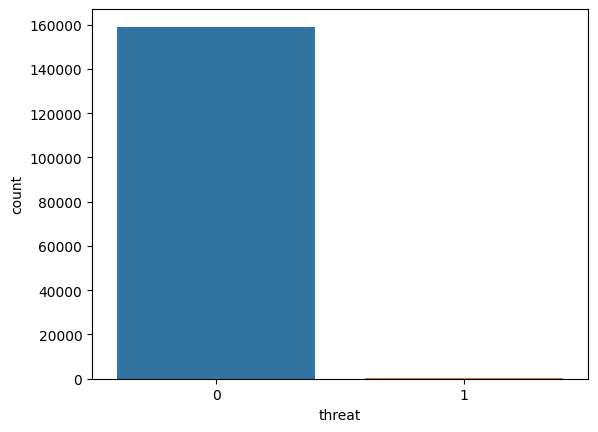

In [ ]:
# Chceck the frequency count of threat.
sns.countplot(x='threat',data=train_data)

We can observe that there are **very few** instances of **threat** words in the **comments**.

In [10]:
# Display each count level for threat column.
train_data.threat.value_counts()

threat
0    159093
1       478
Name: count, dtype: int64

In [ ]:
# Check the toxic percentage.
import plotly.express as px
fig = px.pie(
    train_data.toxic,
    values=train_data.toxic.value_counts().values,
    names=["nontoxic", "toxic"],
    width=500,
    height=500
)
fig.update_layout(
    showlegend=False,
    title="Toxic Rate"
)
fig.update_traces(textinfo='label+percent')
fig.show()

We can observe that there are **very few** instances of **toxic** words in the **comments**.

In [12]:
# Check the severe_toxic percentage.
import plotly.express as px
fig = px.pie(
    train_data.severe_toxic,
    values=train_data.severe_toxic.value_counts().values,
    names=["nonsevere_toxic", "severe_toxic"],
    width=500,
    height=500
)
fig.update_layout(
    showlegend=False,
    title="Severe toxic Rate"
)
fig.update_traces(textinfo='label+percent')
fig.show()

We can observe that there are **very few** instances of **severe_toxic** words in the **comments**.

In [11]:
# Check the obscene percentage.
import plotly.express as px
fig = px.pie(
    train_data.obscene,
    values=train_data.obscene.value_counts().values,
    names=["nonobscene", "obscene"],
    width=500,
    height=500
)
fig.update_layout(
    showlegend=False,
    title="Obscene Rate"
)
fig.update_traces(textinfo='label+percent')
fig.show()

We can observe that there are **very few** instances of **obscene** words in the **comments**.

In [13]:
# Check the threat percentage.
import plotly.express as px
fig = px.pie(
    train_data.threat,
    values=train_data.threat.value_counts().values,
    names=["nonthreat", "threat"],
    width=500,
    height=500
)
fig.update_layout(
    showlegend=False,
    title="Threat Rate"
)
fig.update_traces(textinfo='label+percent')
fig.show()

We can observe that there are **very few** instances of **threat** words in the **comments**.

In [14]:
# Check the insult percentage.
import plotly.express as px
fig = px.pie(
    train_data.insult,
    values=train_data.insult.value_counts().values,
    names=["noninsult", "insult"],
    width=500,
    height=500
)
fig.update_layout(
    showlegend=False,
    title="Insult Rate"
)
fig.update_traces(textinfo='label+percent')
fig.show()

We can observe that there are **very few** instances of **insult** words in the **comments**.

In [15]:
# Check the identity_hate percentage.
import plotly.express as px
fig = px.pie(
    train_data.identity_hate,
    values=train_data.identity_hate.value_counts().values,
    names=["nonidentity_hate", "identity_hate"],
    width=500,
    height=500
)
fig.update_layout(
    showlegend=False,
    title="Identity hate Rate"
)
fig.update_traces(textinfo='label+percent')
fig.show()

We can observe that there are **very few** instances of **identity_hate** words in the **comments**.

In [ ]:
# Let's look at the character length for the rows in the training data.
train_data['char_length'] = train_data['comment_text'].apply(lambda x: len(str(x)))

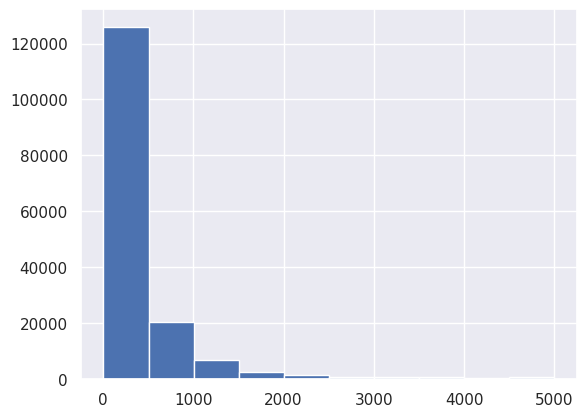

In [ ]:
# look at the histogram plot for text length.
sns.set()
train_data['char_length'].hist()
plt.show()

We can observe that the majority of **comments** have a **length** ranging from **10 to 500** words.


In [ ]:
# Check multi colinearity between numeric varibles for train data.
train_data.select_dtypes(['int64','float64']).corr()

toxic  severe_toxic   obscene    threat    insult  \
toxic          1.000000      0.308619  0.676515  0.157058  0.647518   
severe_toxic   0.308619      1.000000  0.403014  0.123601  0.375807   
obscene        0.676515      0.403014  1.000000  0.141179  0.741272   
threat         0.157058      0.123601  0.141179  1.000000  0.150022   
insult         0.647518      0.375807  0.741272  0.150022  1.000000   
identity_hate  0.266009      0.201600  0.286867  0.115128  0.337736   
char_length   -0.054470      0.010131 -0.042945 -0.008011 -0.045052   

               identity_hate  char_length  
toxic               0.266009    -0.054470  
severe_toxic        0.201600     0.010131  
obscene             0.286867    -0.042945  
threat              0.115128    -0.008011  
insult              0.337736    -0.045052  
identity_hate       1.000000    -0.013647  
char_length        -0.013647     1.000000

<Axes: title={'center': 'Correlation of features & targets'}>

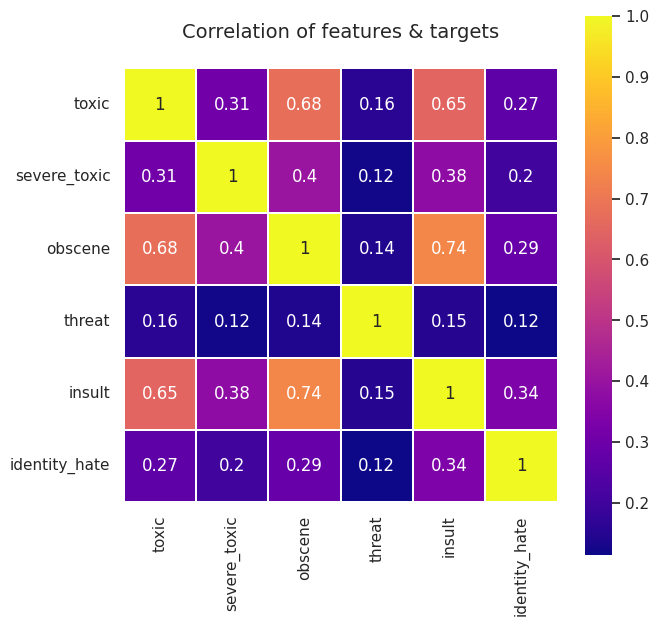

In [ ]:
# Check the multi colinearity plot.
data = train_data[['toxic','severe_toxic','obscene','threat','insult','identity_hate']]
colormap = plt.cm.plasma
plt.figure(figsize=(7,7))
plt.title('Correlation of features & targets',y=1.05,size=14)
sns.heatmap(data.astype(float).corr(),linewidths=0.1,vmax=1.0,square=True,cmap=colormap,
           linecolor='white',annot=True)

The **correlation matrix** shows interesting things :

**toxic** is clearly correlated with **obscene** and **insult** (0.68 and 0.65)

**toxic** and **severe_toxic** are only got a 0.31 correlation factor

**insult** and **obscene** have a correlation factor of 0.74

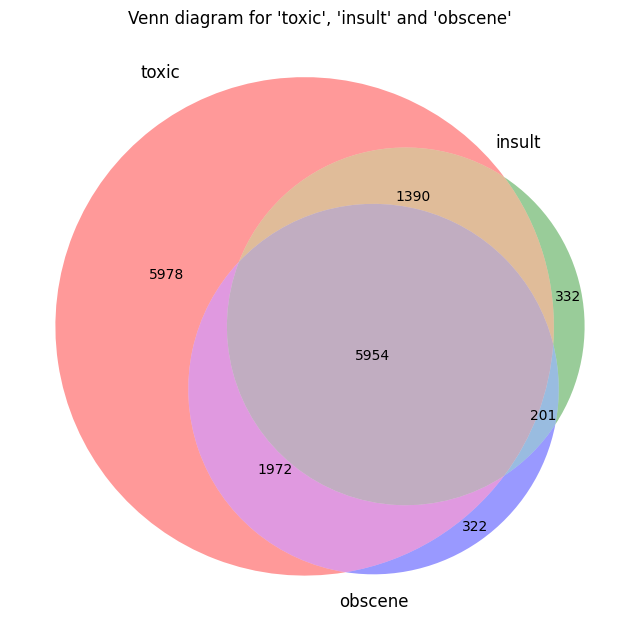

In [16]:
t = train_data[(train_data['toxic'] == 1) & (train_data['insult'] == 0) & (train_data['obscene'] == 0)].shape[0]
i = train_data[(train_data['toxic'] == 0) & (train_data['insult'] == 1) & (train_data['obscene'] == 0)].shape[0]
o = train_data[(train_data['toxic'] == 0) & (train_data['insult'] == 0) & (train_data['obscene'] == 1)].shape[0]

t_i = train_data[(train_data['toxic'] == 1) & (train_data['insult'] == 1) & (train_data['obscene'] == 0)].shape[0]
t_o = train_data[(train_data['toxic'] == 1) & (train_data['insult'] == 0) & (train_data['obscene'] == 1)].shape[0]
i_o = train_data[(train_data['toxic'] == 0) & (train_data['insult'] == 1) & (train_data['obscene'] == 1)].shape[0]

t_i_o = train_data[(train_data['toxic'] == 1) & (train_data['insult'] == 1) & (train_data['obscene'] == 1)].shape[0]


# Make the diagram
plt.figure(figsize=(8, 8))
plt.title("Venn diagram for 'toxic', 'insult' and 'obscene'")
venn3(subsets = (t, i, t_i, o, t_o, i_o, t_i_o),
      set_labels=('toxic', 'insult', 'obscene'))
plt.show()

This venn diagram demonstrates the correlations found in the previous visualization.

There is only a small part of **insult** and **obscene** that are not also labelled **toxic**.

**5954** comments are labelled with all **3** categories.

In [18]:
# Flag safe and unsafe comments.
train_data['safe_unsafe'] = train_data.apply(
    lambda row: 'unsafe' if (
        row['toxic'] ==1 or
        row['severe_toxic'] ==1 or
        row['obscene'] ==1 or
        row['threat'] ==1 or
        row['insult'] ==1 or
        row['identity_hate'] ==1
    ) else 'safe',
    axis=1
)

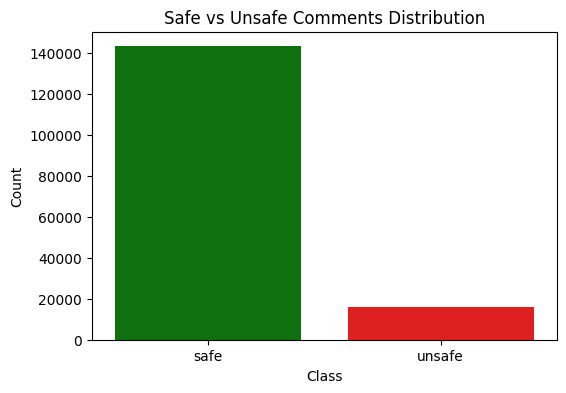

In [ ]:
# Check the frquency of safe and unsafe comments.
plt.figure(figsize=(6,4))
sns.countplot(x='safe_unsafe',data=train_data, palette=['green', 'red'])
plt.title("Safe vs Unsafe Comments Distribution")
plt.xlabel("Class")
plt.ylabel("Count")
plt.show()

We can observe that the **majority** of the **comments** are labeled as **safe**.

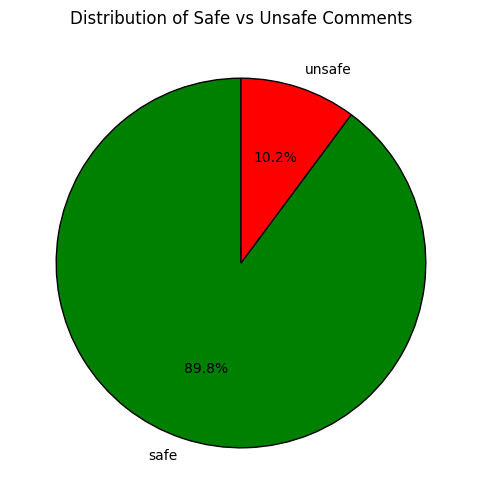

In [ ]:
# Calculate counts of safe and unsafe
counts = train_data['safe_unsafe'].value_counts()

# Plot pie chart with percentages
plt.figure(figsize=(6, 6))
plt.pie(
    counts,
    labels=counts.index,
    autopct='%1.1f%%',  # show percentages with 1 decimal
    startangle=90,
    colors=['green', 'red'],  # optional colors
    wedgeprops={'edgecolor': 'black'}
)
plt.title('Distribution of Safe vs Unsafe Comments')
plt.show()

We can observe that the **majority** of the **comments** are labeled as **safe**.

In [ ]:
# Check the frquency of safe and unsafe comments.
train_data['safe_unsafe'].value_counts()

safe_unsafe
safe      143346
unsafe     16225
Name: count, dtype: int64

In [19]:
# Let's check unsafe comments frequnecy with respect to labels.
df_distribution = train_data[train_data['safe_unsafe']=='unsafe'][['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']].sum()\
                            .to_frame()\
                            .rename(columns={0: 'count'})\
                            .sort_values('count')

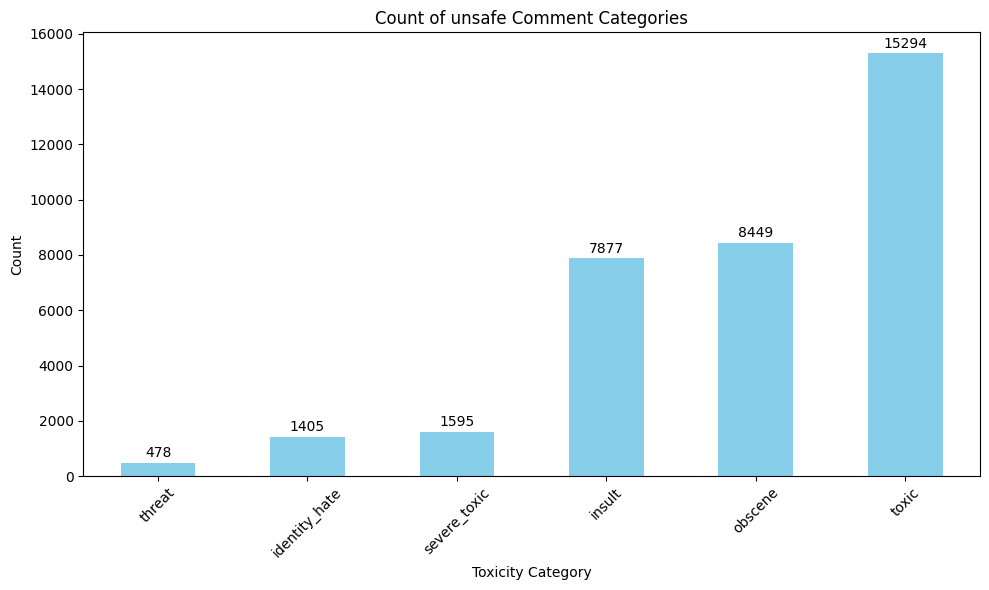

In [20]:
# Plot
plt.figure(figsize=(10, 6))
ax = df_distribution['count'].plot(kind='bar', color='skyblue')

plt.xlabel('Toxicity Category')
plt.ylabel('Count')
plt.title('Count of unsafe Comment Categories')
plt.xticks(rotation=45)

# Add value labels on top of bars
for idx, value in enumerate(df_distribution['count']):
    plt.text(idx, value + 100, str(value), ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

The **distribution** indicates a higher prevalence of **toxicity**-related comments compared to **other classes**.



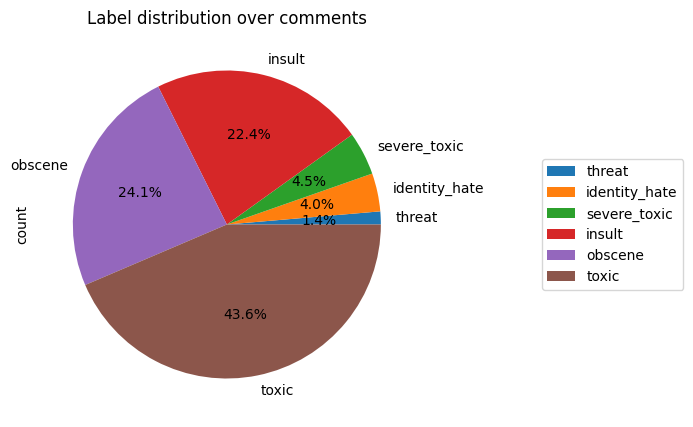

In [ ]:
df_distribution.plot.pie(y='count',title='Label distribution over comments',figsize=(5, 5), autopct='%1.1f%%').legend(loc='center left', bbox_to_anchor=(1.3, 0.5))

The **distribution** indicates a higher prevalence of **toxicity**-related comments compared to **other classes**.

In [ ]:
# Display the frequency of each label.
df_distribution.sort_values('count', ascending=False)

count
toxic          15294
obscene         8449
insult          7877
severe_toxic    1595
identity_hate   1405
threat           478

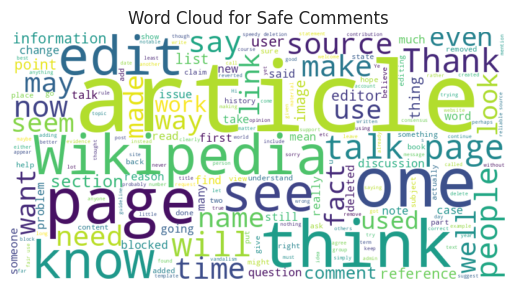

In [ ]:
# Plot the word cloud of safe comments.
comments = ' '.join(train_data[train_data['safe_unsafe']=='safe']['comment_text'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(comments)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Safe Comments')
plt.show()

We can observe from the safe comments word cloud that terms like **article**, **wikipedia**, **page**, **think**, and **edit** are among the most frequently occurring words in the comments.

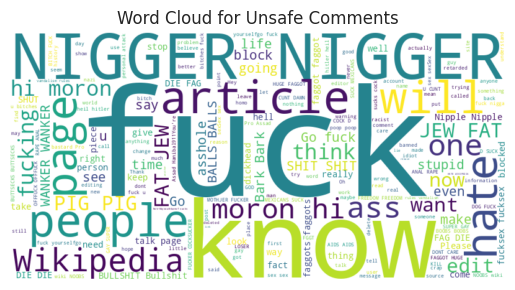

In [ ]:
# Plot the word cloud of unsafe comments.
comments = ' '.join(train_data[train_data['safe_unsafe']=='unsafe']['comment_text'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(comments)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Unsafe Comments')
plt.show()

We can observe from the unsafe comments word cloud that terms like **fuck**, **nigger**, **fucking**, **hate**, and **fat** are among the most frequently occurring words in the comments.

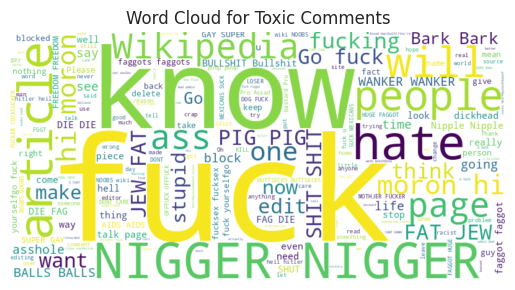

In [ ]:
# Plot the word cloud of toxic comments.
comments = ' '.join(train_data[train_data['toxic']==1]['comment_text'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(comments)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Toxic Comments')
plt.show()

We can observe from the toxic comments word cloud that terms like **fuck**, **nigger**, **ass**, **hate**, and **fat** are among the most frequently occurring words in the comments.

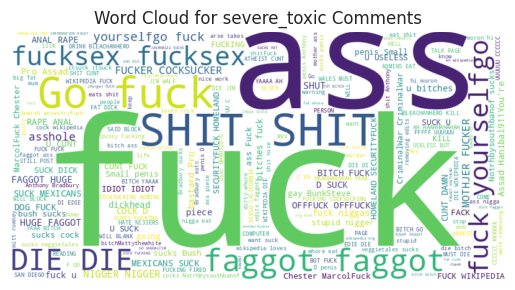

In [ ]:
# Plot the word cloud of severe_toxic comments.
comments = ' '.join(train_data[train_data['severe_toxic']==1]['comment_text'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(comments)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for severe_toxic Comments')
plt.show()

We can observe from the severe_toxic comments word cloud that terms like **fuck**, **shit**, **ass**, **die**, and **faggot** are among the most frequently occurring words in the comments.

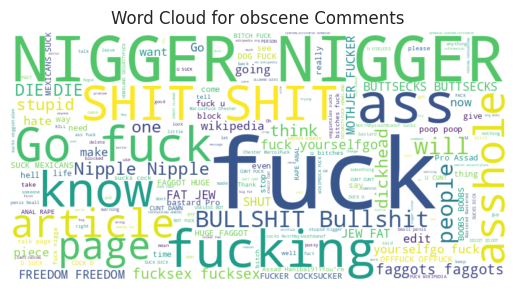

In [ ]:
# Plot the word cloud of obscene comments.
comments = ' '.join(train_data[train_data['obscene']==1]['comment_text'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(comments)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for obscene Comments')
plt.show()

We can observe from the obscene comments word cloud that terms like **fuck**, **bullshit**, **ass**, **nigger**, **asshole** and **nipple** are among the most frequently occurring words in the comments.

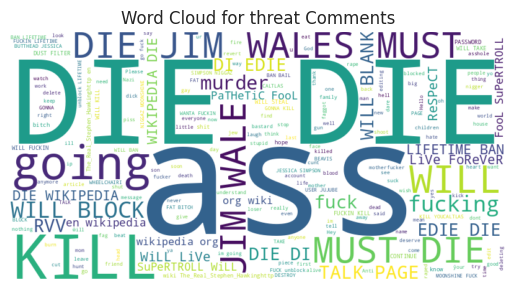

In [ ]:
# Plot the word cloud of threat comments.
comments = ' '.join(train_data[train_data['threat']==1]['comment_text'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(comments)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for threat Comments')
plt.show()

We can observe from the threat comments word cloud that terms like **Die**, **Ass**, **Kill**, and **Murder** are among the most frequently occurring words in the comments.

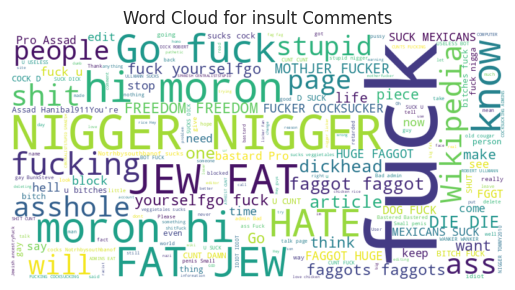

In [ ]:
# Plot the word cloud of insult comments.
comments = ' '.join(train_data[train_data['insult']==1]['comment_text'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(comments)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for insult Comments')
plt.show()

We can observe from the insult comments word cloud that terms like **Fuck**, **Jew**, **Fat**, **Moron**, **Stupid** and **Nigger** are among the most frequently occurring words in the comments.

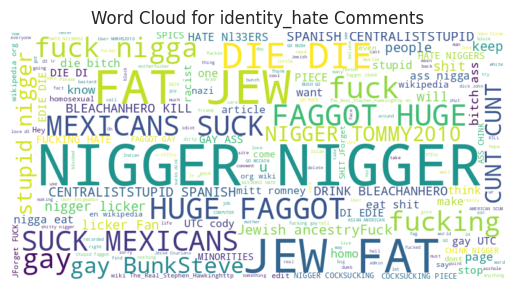

In [ ]:
# Plot the word cloud of identity_hate comments.
comments = ' '.join(train_data[train_data['identity_hate']==1]['comment_text'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(comments)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for identity_hate Comments')
plt.show()

We can observe from the identity_hate comments word cloud that terms like **Nigger**, **Suck**, **Fat**, **Gay**, **Die** and **Faggot** are among the most frequently occurring words in the comments.

In [ ]:
# Check the top 5 records from training data.
train_data.head()

id                                       comment_text  toxic  \
0  0000997932d777bf  Explanation\nWhy the edits made under my usern...      0   
1  000103f0d9cfb60f  D'aww! He matches this background colour I'm s...      0   
2  000113f07ec002fd  Hey man, I'm really not trying to edit war. It...      0   
3  0001b41b1c6bb37e  "\nMore\nI can't make any real suggestions on ...      0   
4  0001d958c54c6e35  You, sir, are my hero. Any chance you remember...      0   

   severe_toxic  obscene  threat  insult  identity_hate  char_length  \
0             0        0       0       0              0          264   
1             0        0       0       0              0          112   
2             0        0       0       0              0          233   
3             0        0       0       0              0          622   
4             0        0       0       0              0           67   

  safe_unsafe  
0        safe  
1        safe  
2        safe  
3        safe  
4        safe

In [ ]:
# Convert all labels data into a list and drop labels.
train_data['labels'] = train_data[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']].values.tolist()
train_data.drop(['id', 'toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate','char_length','safe_unsafe'], axis=1, inplace=True)

# Convert comments into lower case and remove empty space.
train_data['comment_text'] = train_data['comment_text'].str.lower()
train_data['comment_text'] = train_data['comment_text'].str.replace("\xa0", " ", regex=False).str.split().str.join(" ")

# Split train_data into train and validation sets(80:20 ratio).
train_df, val_df = train_test_split(train_data, test_size=0.2, random_state=474)


In [ ]:
# ==================== Hyperparameters ====================
MAX_LEN = 128
TRAIN_BATCH_SIZE = 16
VALID_BATCH_SIZE = 32
EPOCHS = 1
LEARNING_RATE = 1e-5
NUM_WORKERS = 2


In [ ]:
# ==================== Dataset Class ====================
class MultiLabelDataset(Dataset):
    """
    Dataset for multi-label text classification
    """
    def __init__(self, dataframe, tokenizer, max_len: int, eval_mode: bool = True):
        self.data = dataframe
        self.tokenizer = tokenizer
        self.text = dataframe.comment_text
        self.eval_mode = eval_mode
        self.max_len = max_len
        if self.eval_mode:
            self.targets = self.data.labels

    def __len__(self):
        return len(self.text)

    def __getitem__(self, index):
        text = str(self.text.iloc[index])
        text = " ".join(text.split())

        inputs = self.tokenizer.encode_plus(
            text,
            None,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            truncation=True,
            return_token_type_ids=True
        )

        output = {
            'ids': torch.tensor(inputs['input_ids'], dtype=torch.long),
            'mask': torch.tensor(inputs['attention_mask'], dtype=torch.long),
            'token_type_ids': torch.tensor(inputs['token_type_ids'], dtype=torch.long),
        }

        if self.eval_mode:
            output['targets'] = torch.tensor(self.targets.iloc[index], dtype=torch.float)

        return output

In [ ]:
# ==================== Tokenizer and DataLoader ====================
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
train_dataset = MultiLabelDataset(train_df, tokenizer, MAX_LEN,eval_mode=True)
val_dataset = MultiLabelDataset(val_df, tokenizer, MAX_LEN,eval_mode=True)

train_loader = DataLoader(train_dataset, batch_size=TRAIN_BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
val_loader = DataLoader(val_dataset, batch_size=VALID_BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)


In [ ]:
# ==================== Model Class ====================
class DistilBERTClass(torch.nn.Module):
    def __init__(self):
        super(DistilBERTClass, self).__init__()
        self.l1 = DistilBertModel.from_pretrained("distilbert-base-uncased")
        self.pre_classifier = torch.nn.Linear(768, 768)
        self.dropout = torch.nn.Dropout(0.1)
        self.classifier = torch.nn.Linear(768, 6)

    def forward(self, input_ids, attention_mask, token_type_ids):
        distilbert_output = self.l1(input_ids=input_ids, attention_mask=attention_mask)
        hidden_state = distilbert_output.last_hidden_state
        pooled_output = hidden_state[:, 0]
        pooled_output = self.pre_classifier(pooled_output)
        pooled_output = torch.nn.Tanh()(pooled_output)
        pooled_output = self.dropout(pooled_output)
        return self.classifier(pooled_output)

model = DistilBERTClass().to(device)
optimizer = torch.optim.Adam(params=model.parameters(), lr=LEARNING_RATE)


In [ ]:
# ==================== Loss Function ====================
def loss_fn(outputs, targets):
    return torch.nn.BCEWithLogitsLoss()(outputs, targets)

In [ ]:
# ==================== Training Loop ====================
def train_one_epoch(model, loader, optimizer):
    model.train()
    total_loss = 0
    for data in tqdm(loader):
        ids = data['ids'].to(device)
        mask = data['mask'].to(device)
        token_type_ids = data['token_type_ids'].to(device)
        targets = data['targets'].to(device)

        outputs = model(ids, mask, token_type_ids)
        loss = loss_fn(outputs, targets)
        total_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    return total_loss / len(loader)

In [ ]:
# ==================== Evaluation Loop ====================
def evaluate(model, loader):
    model.eval()
    final_outputs = []
    final_targets = []
    with torch.no_grad():
        for data in tqdm(loader):
            ids = data['ids'].to(device)
            mask = data['mask'].to(device)
            token_type_ids = data['token_type_ids'].to(device)
            targets = data['targets'].to(device)

            outputs = model(ids, mask, token_type_ids)
            final_outputs.append(torch.sigmoid(outputs).cpu().numpy())
            final_targets.append(targets.cpu().numpy())

    return np.vstack(final_outputs), np.vstack(final_targets)

In [ ]:
# ==================== Run Training and Evaluation ====================
for epoch in range(EPOCHS):
    train_loss = train_one_epoch(model, train_loader, optimizer)
    print(f"Epoch {epoch+1}, Train Loss: {train_loss:.4f}")

train_preds, train_targets = evaluate(model, train_loader)
val_preds, val_targets = evaluate(model, val_loader)

100%|██████████| 7979/7979 [13:29<00:00,  9.86it/s]


Epoch 1, Train Loss: 0.0494


100%|██████████| 998/998 [00:54<00:00, 18.15it/s]


In [ ]:
# ==================== Thresholding ====================
threshold = 0.5
train_bin = (train_preds > threshold).astype(int)
val_bin = (val_preds > threshold).astype(int)

In [ ]:
# ==================== Metrics ====================
labels = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]

print("\n--- Training Classification Report ---")
print(classification_report(train_targets, train_bin, target_names=labels))

print("\n--- Validation Classification Report ---")
print(classification_report(val_targets, val_bin, target_names=labels))

# ROC AUC Score
print("\n--- ROC AUC Scores ---")
print("Train:", roc_auc_score(train_targets, train_preds, average="macro"))
print("Val:", roc_auc_score(val_targets, val_preds, average="macro"))


--- Training Classification Report ---
               precision    recall  f1-score   support

        toxic       0.89      0.83      0.86     12242
 severe_toxic       0.73      0.12      0.20      1271
      obscene       0.85      0.87      0.86      6771
       threat       0.82      0.17      0.28       392
       insult       0.80      0.78      0.79      6302
identity_hate       0.67      0.55      0.60      1123

    micro avg       0.85      0.77      0.81     28101
    macro avg       0.79      0.55      0.60     28101
 weighted avg       0.84      0.77      0.79     28101
  samples avg       0.07      0.07      0.07     28101


--- Validation Classification Report ---
               precision    recall  f1-score   support

        toxic       0.86      0.79      0.82      3052
 severe_toxic       0.66      0.10      0.18       324
      obscene       0.84      0.85      0.85      1678
       threat       0.77      0.12      0.20        86
       insult       0.78      0.74

The **precision**, **recall**, **F1 score**, and **ROC AUC** values for both the training and validation datasets indicate **strong performance**. The **consistency** across these **metrics** suggests that the model is performing **reliably** on both **seen** and **unseen** data.

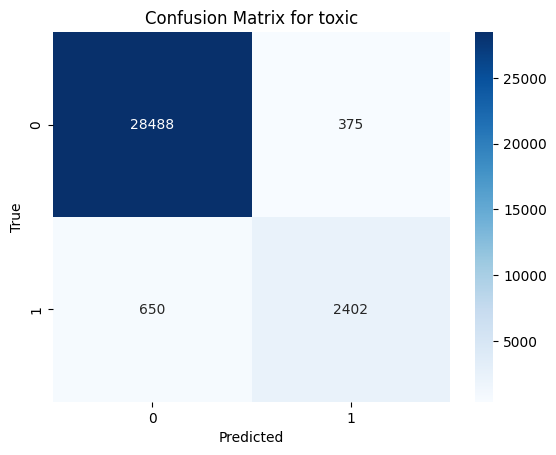

In [ ]:
# ==================== Confusion Matrix for One Label(toxic) Example ====================
def plot_confusion(label_index, title):
    cm = confusion_matrix(val_targets[:, label_index], val_bin[:, label_index])
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix for {title}')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

plot_confusion(0, labels[0])  # For "toxic"

The false prediction rate for the **toxic** class appears to be quite **low**.

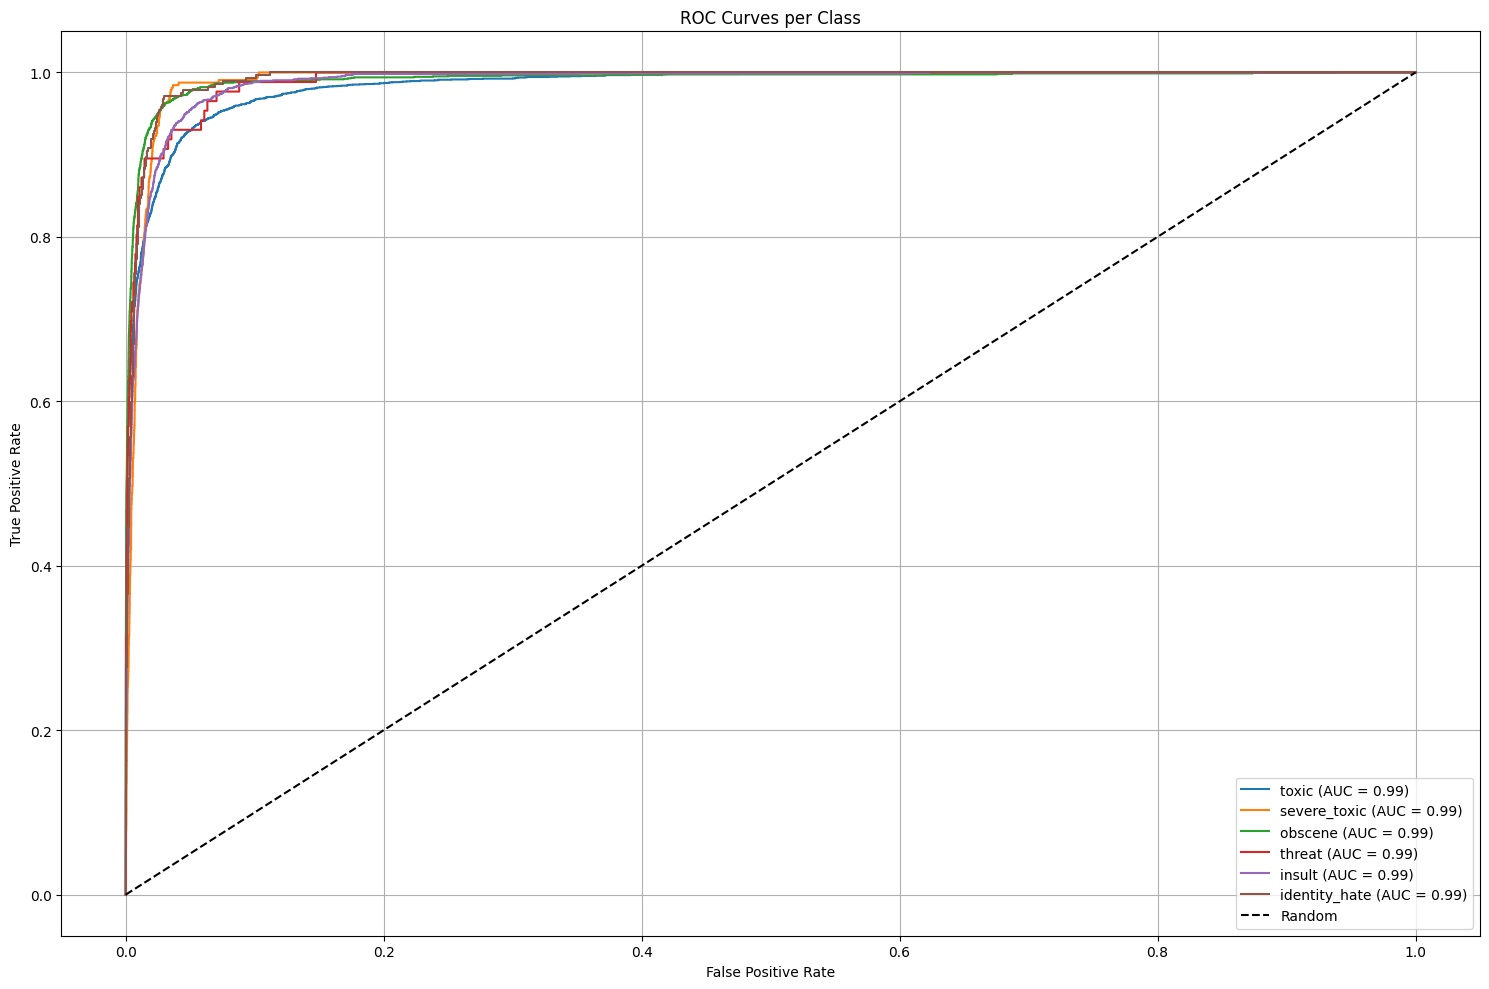

In [ ]:
#Plot ROC Curve Plot (Per Class)
plt.figure(figsize=(15, 10))

for i, label in enumerate(labels):
    fpr, tpr, _ = roc_curve(val_targets[:, i], val_preds[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{label} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves per Class')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()

The Area Under the Curve (**AUC**) is close to **100%**, indicating that the **model** demonstrates **excellent** performance.

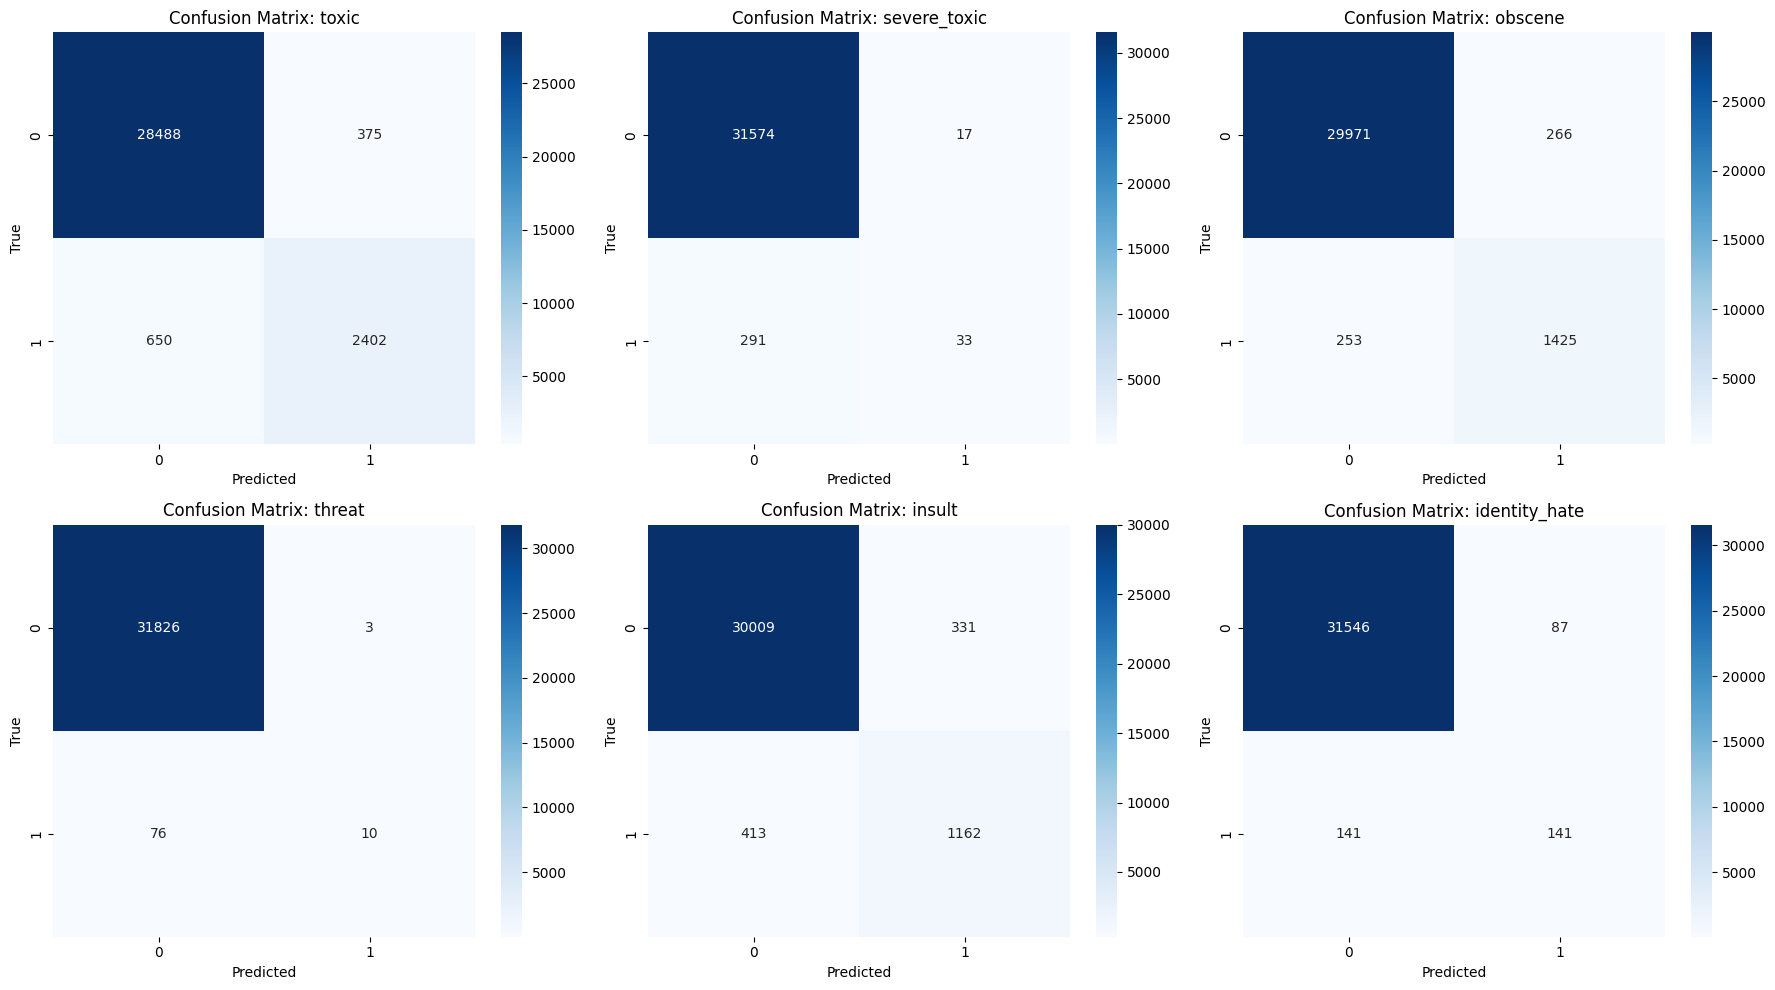

In [ ]:
#Confusion Matrices (Per Class)
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

for i, label in enumerate(labels):
    cm = confusion_matrix(val_targets[:, i], val_bin[:, i])
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[i])
    axes[i].set_title(f'Confusion Matrix: {label}')
    axes[i].set_xlabel('Predicted')
    axes[i].set_ylabel('True')

plt.tight_layout()
plt.show()


The **model** demonstrates **consistently strong** performance, as evidenced by the l**ow false positive rate** across all labels.

In [ ]:
# ==================== Save Model ====================
torch.save(model.state_dict(), "toxic_model.pt")

In [ ]:
# ==================== Load and Preprocess Test Data - Google Colab Platform ====================
try:
    test_data = pd.read_csv('test.csv.zip')
except Exception as e:
    raise RuntimeError("Test data not found.") from e

# Clean test comments
test_data['comment_text'] = test_data['comment_text'].str.lower()
test_data['comment_text'] = test_data['comment_text'].str.replace("\xa0", " ", regex=False).str.split().str.join(" ")

# ==================== Prepare Test Dataset ====================
test_set = MultiLabelDataset(test_data, tokenizer, MAX_LEN, eval_mode=False)
test_loader = DataLoader(test_set, batch_size=TRAIN_BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)


In [ ]:
# ==================== Load and Preprocess Test Data - Kaggle Platform ====================
try:
    test_data = pd.read_csv('/kaggle/input/toxicv1/test.csv')
except Exception as e:
    raise RuntimeError("Test data not found.") from e

# Clean test comments
test_data['comment_text'] = test_data['comment_text'].str.lower()
test_data['comment_text'] = test_data['comment_text'].str.replace("\xa0", " ", regex=False).str.split().str.join(" ")

# ==================== Prepare Test Dataset ====================
test_set = MultiLabelDataset(test_data, tokenizer, MAX_LEN, eval_mode=False)
test_loader = DataLoader(test_set, batch_size=TRAIN_BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)



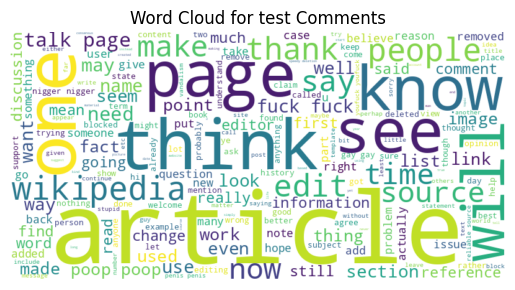

In [ ]:
# Plot the word cloud for test comments.
comments = ' '.join(test_data['comment_text'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(comments)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for test Comments')
plt.show()

We can observe from the test comments word cloud that terms like **article**, **wikipedia**, **page**, **think**, and **one** are among the most frequently occurring words in the comments.

In [ ]:
# ==================== Inference Function ====================
def test(model, dataloader):
    model.eval()
    predictions = []

    with torch.inference_mode():
        for data in tqdm(dataloader, desc="Predicting"):
            ids = data['ids'].to(device)
            mask = data['mask'].to(device)
            token_type_ids = data['token_type_ids'].to(device)

            outputs = model(ids, mask, token_type_ids)
            probas = torch.sigmoid(outputs)
            predictions.append(probas.cpu())

    return torch.cat(predictions, dim=0)

In [ ]:
# ==================== Run Inference ====================
all_test_pred = test(model, test_loader)

Predicting: 100%|██████████| 9573/9573 [04:35<00:00, 34.71it/s]


In [ ]:
# ==================== Post-processing ====================
label_columns = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]

# Add predictions to DataFrame
submit_df = test_data[['id']].copy()  # Only keep ID column for submission

for i, label in enumerate(label_columns):
    submit_df[label] = all_test_pred[:, i].numpy()

# Derive binary 'safe_unsafe' label
submit_df['safe_unsafe'] = submit_df[label_columns].apply(
    lambda row: 'unsafe' if any(row > 0.5) else 'safe',
    axis=1
)

In [ ]:
# Check the safe and unsafe value count.
submit_df['safe_unsafe'].value_counts()

safe_unsafe
safe      119299
unsafe     33865
Name: count, dtype: int64

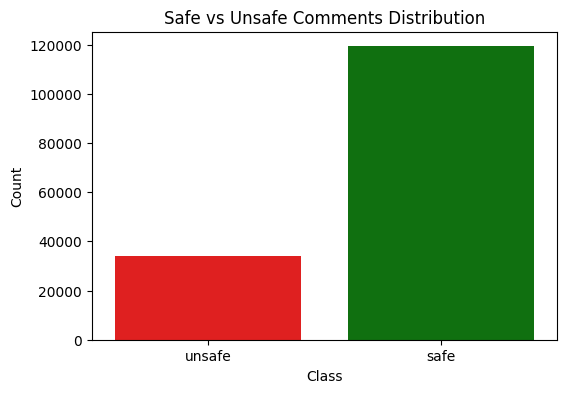

In [ ]:
# Check the frquency of safe and unsafe comments.
plt.figure(figsize=(6,4))
sns.countplot(x='safe_unsafe',data=submit_df, palette=['red','green'])
plt.title("Safe vs Unsafe Comments Distribution")
plt.xlabel("Class")
plt.ylabel("Count")
plt.show()

A **significant** portion of the **test data** consists of **safe comments**.

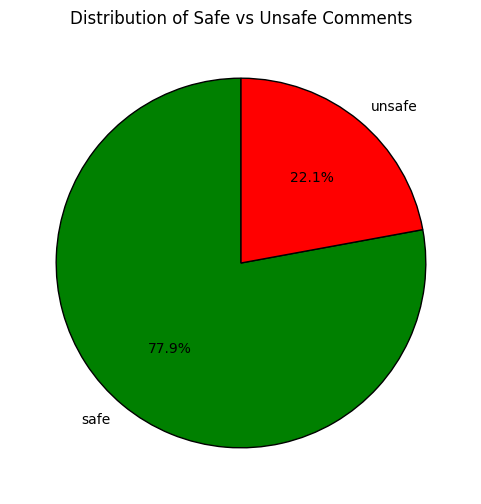

In [ ]:
# Calculate counts of safe and unsafe.
counts = submit_df['safe_unsafe'].value_counts()

# Plot pie chart with percentages.
plt.figure(figsize=(6, 6))
plt.pie(
    counts,
    labels=counts.index,
    autopct='%1.1f%%',  # show percentages with 1 decimal
    startangle=90,
    colors=['green', 'red'],  # optional colors
    wedgeprops={'edgecolor': 'black'}
)
plt.title('Distribution of Safe vs Unsafe Comments')
plt.show()

A **significant** portion of the **test data** consists of **safe comments**.

In [ ]:
# ==================== Save Submission ====================
submit_df.to_csv('submission.csv', index=False)
print("Predictions saved to submission.csv")

Predictions saved to submission.csv


In [ ]:
# ==================== Summary ====================
print("Model training and inference complete. Results saved to submission.csv")
print(submit_df.head())

Model training and inference complete. Results saved to submission.csv
                 id     toxic  severe_toxic   obscene    threat    insult  \
0  00001cee341fdb12  0.993767      0.466471  0.977314  0.064559  0.946534   
1  0000247867823ef7  0.000895      0.000321  0.000537  0.000287  0.000447   
2  00013b17ad220c46  0.001047      0.000335  0.000579  0.000274  0.000490   
3  00017563c3f7919a  0.000784      0.000363  0.000502  0.000349  0.000461   
4  00017695ad8997eb  0.001437      0.000245  0.000522  0.000243  0.000488   

   identity_hate safe_unsafe  
0       0.460493      unsafe  
1       0.000366        safe  
2       0.000435        safe  
3       0.000412        safe  
4       0.000340        safe  


In [ ]:
# Perform EDA on test predictions data.

In [ ]:
# Get the lable sum with respect to unsafe comments.
df_distribution = submit_df[submit_df['safe_unsafe']=='unsafe'][['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']].sum()\
                            .to_frame()\
                            .rename(columns={0: 'count'})\
                            .sort_values('count')

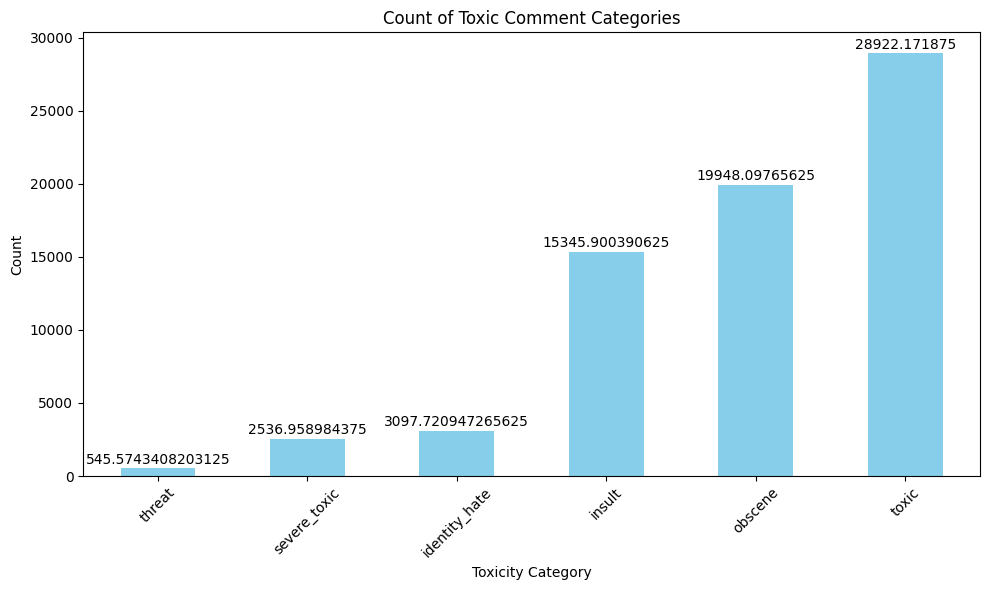

In [ ]:
# Plot
plt.figure(figsize=(10, 6))
ax = df_distribution['count'].plot(kind='bar', color='skyblue')

plt.xlabel('Toxicity Category')
plt.ylabel('Count')
plt.title('Count of Toxic Comment Categories')
plt.xticks(rotation=45)

# Add value labels on top of bars
for idx, value in enumerate(df_distribution['count']):
    plt.text(idx, value + 100, str(value), ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

The **test data** also contains a significantly **higher** number of **toxic** comments compared to **other categories**.

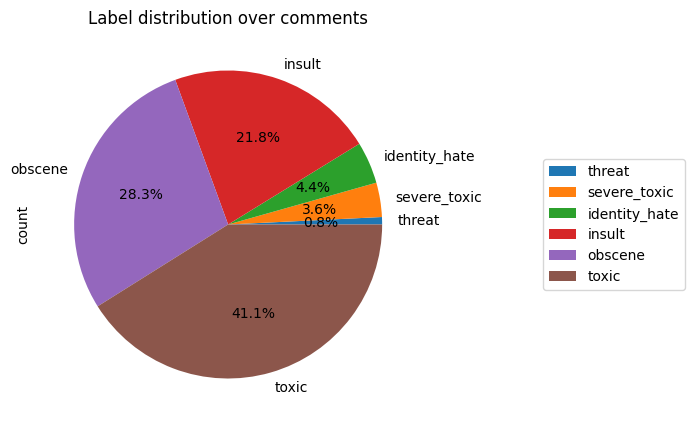

In [ ]:
df_distribution.plot.pie(y='count',title='Label distribution over comments',figsize=(5, 5), autopct='%1.1f%%').legend(loc='center left', bbox_to_anchor=(1.3, 0.5))

The **test data** also contains a significantly **higher** number of **toxic** comments compared to **other categories**.

In [ ]:
# ==================== Post-processing ====================
label_columns = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]

# Add predictions to DataFrame
submit_df_1 = test_data.copy()

for i, label in enumerate(label_columns):
    submit_df_1[label] = all_test_pred[:, i].numpy()

# Derive binary 'safe_unsafe' label
submit_df_1['safe_unsafe'] = submit_df_1[label_columns].apply(
    lambda row: 'unsafe' if any(row > 0.5) else 'safe',
    axis=1
)

In [ ]:
submit_df_1.head()

id                                       comment_text  \
0  00001cee341fdb12  yo bitch ja rule is more succesful then you'll...   
1  0000247867823ef7    == from rfc == the title is fine as it is, imo.   
2  00013b17ad220c46     " == sources == * zawe ashton on lapland — / "   
3  00017563c3f7919a  :if you have a look back at the source, the in...   
4  00017695ad8997eb          i don't anonymously edit articles at all.   

      toxic  severe_toxic   obscene    threat    insult  identity_hate  \
0  0.993767      0.466471  0.977314  0.064559  0.946534       0.460493   
1  0.000895      0.000321  0.000537  0.000287  0.000447       0.000366   
2  0.001047      0.000335  0.000579  0.000274  0.000490       0.000435   
3  0.000784      0.000363  0.000502  0.000349  0.000461       0.000412   
4  0.001437      0.000245  0.000522  0.000243  0.000488       0.000340   

  safe_unsafe  
0      unsafe  
1        safe  
2        safe  
3        safe  
4        safe

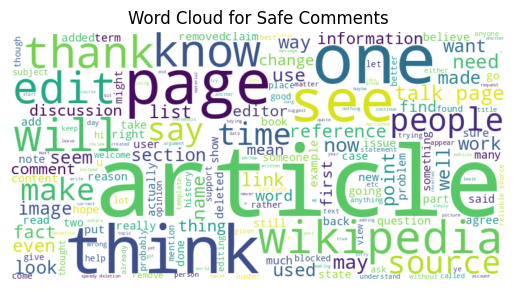

In [ ]:
# Plot the word cloud of safe comments.
comments = ' '.join(submit_df_1[submit_df_1['safe_unsafe']=='safe']['comment_text'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(comments)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Safe Comments')
plt.show()

We can observe from the safe comments word cloud that terms like **article**, **wikipedia**, **page**, **think**, and **one** are among the most frequently occurring words in the comments.

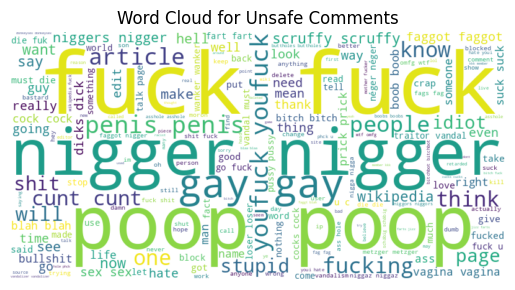

In [ ]:
# Plot the word cloud of unsafe comments.
comments = ' '.join(submit_df_1[submit_df_1['safe_unsafe']=='unsafe']['comment_text'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(comments)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Unsafe Comments')
plt.show()

We can observe from the unsafe comments word cloud that terms like **fuck**, **nigger**, **gay**, **poop**, and **cunt** are among the most frequently occurring words in the comments.

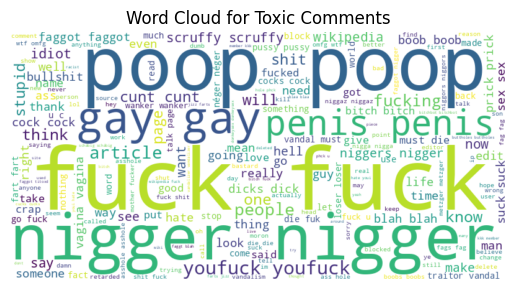

In [ ]:
# Plot the word cloud of toxic comments.
comments = ' '.join(submit_df_1[submit_df_1['toxic']>0.5]['comment_text'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(comments)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Toxic Comments')
plt.show()

We can observe from the toxic comments word cloud that terms like **fuck**, **nigger**, **gay**, **poop**, and **penis** are among the most frequently occurring words in the comments.

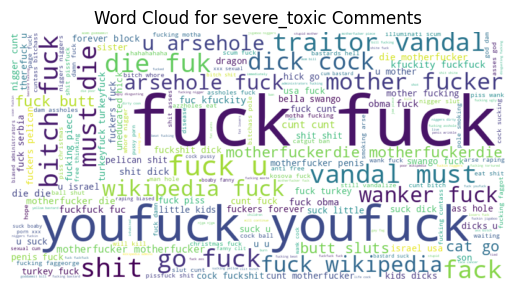

In [ ]:
# Plot the word cloud of severe_toxic comments.
comments = ' '.join(submit_df_1[submit_df_1['severe_toxic']>0.5]['comment_text'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(comments)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for severe_toxic Comments')
plt.show()

We can observe from the severe_toxic comments word cloud that terms like **fuck**, **youfuck**, **bitch**, **cock**, and **dick** are among the most frequently occurring words in the comments.

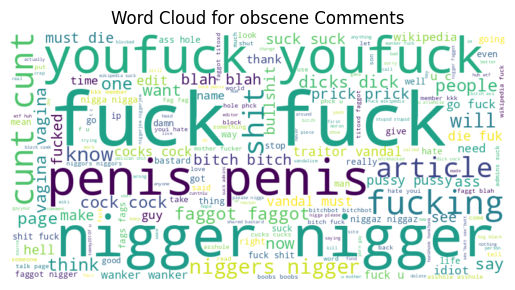

In [ ]:
# Plot the word cloud of obscene comments.
comments = ' '.join(submit_df_1[submit_df_1['obscene']>0.5]['comment_text'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(comments)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for obscene Comments')
plt.show()

We can observe from the obscene comments word cloud that terms like **fuck**, **nigger**, **penis**, **youfuck**, and **cunt** are among the most frequently occurring words in the comments.

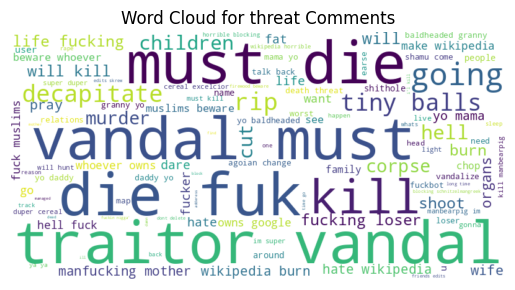

In [ ]:
# Plot the word cloud of threat comments.
comments = ' '.join(submit_df_1[submit_df_1['threat']>0.5]['comment_text'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(comments)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for threat Comments')
plt.show()

We can observe from the threat comments word cloud that terms like **fuck**, **die**, **traitor**, **vandal**, and **kill** are among the most frequently occurring words in the comments.

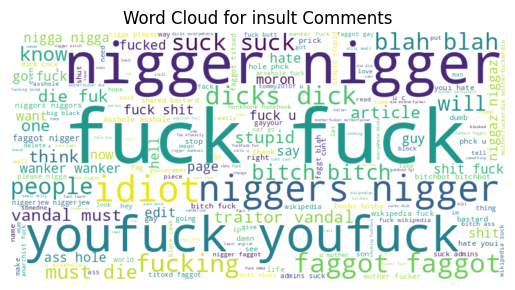

In [ ]:
# Plot the word cloud of insult comments.
comments = ' '.join(submit_df_1[submit_df_1['insult']>0.5]['comment_text'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(comments)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for insult Comments')
plt.show()

We can observe from the insult comments word cloud that terms like **fuck**, **nigger**, **idiot**, **youfuck**, and **faggot** are among the most frequently occurring words in the comments.

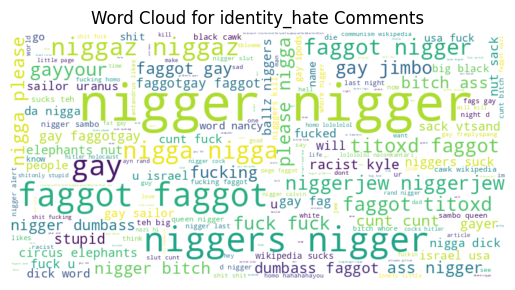

In [ ]:
# Plot the word cloud of identity_hate comments.
comments = ' '.join(submit_df_1[submit_df_1['identity_hate']>0.5]['comment_text'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(comments)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for identity_hate Comments')
plt.show()

We can observe from the identity_hate comments word cloud that terms like **nigger**, **gay** and **faggot** are among the most frequently occurring words in the comments.